In [1]:
%load_ext autoreload
%autoreload 2

In [135]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.spatial.transform import Rotation as R


from AdjQuat import utils
from AdjQuat import simulators
from AdjQuat import solutions
from AdjQuat.procrustes_wasserstein import procrustes_wasserstein_2d_3d_dram, procrustes_wasserstein_2d_3d_svd

## 1. Data generation

First we will set up our data generation process.

In [528]:
# We define a manual seed for reproducilibity.
torch.manual_seed(0)

In [529]:
# First we generate random points in 3D space
npts = 50
xyz = torch.randn(npts, 3, dtype=torch.double)

In [530]:
xyz[0] # just to check our first point is the same for different runs

tensor([-2.3104, -0.3733, -1.0608], dtype=torch.float64)

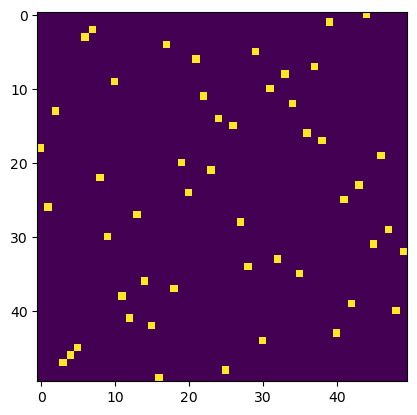

In [531]:
# Create a permutation matrix
torch.manual_seed(0)
permutation_idx = torch.randperm(npts)
permutation_matrix = torch.zeros(npts,npts, dtype=torch.double)
permutation_matrix[torch.arange(npts), permutation_idx] = 1
plt.imshow(permutation_matrix)

In [532]:
xyz_permuted = torch.matmul(permutation_matrix, xyz)

# 2. Find ordering in 3d -> 3d problem with no misrotation

In [533]:
C = torch.cdist(xyz,xyz_permuted, p=2) ** 2

In [534]:
p = q = np.ones(npts)
transport_plan, log = ot.emd(p, q, C.numpy(), log=True)

In [535]:
np.allclose(permutation_matrix.T, transport_plan)

True

In [536]:
np.allclose(xyz_permuted.numpy(), transport_plan.T @ xyz.numpy())

True

# 3. optimize rotation

Start with a slightly rotated and permuted point cloud xyz_permuted_rotated and the projection along z before rotation and permuting

/tmp/ipykernel_2434601/1587677271.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  xyz_permuted_rotated = xyz[permutation_idx] @ rotation


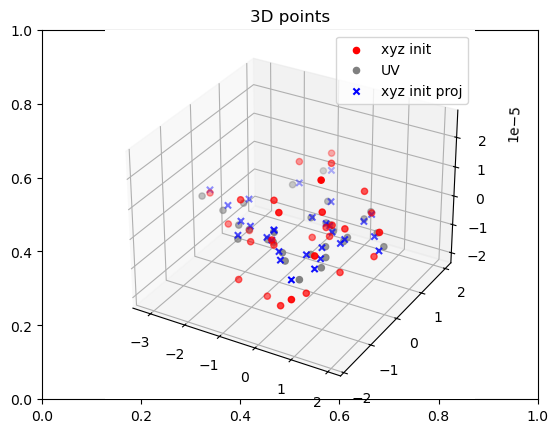

In [167]:
torch.manual_seed(0)

npts = 30
xyz = torch.randn(npts, 3, dtype=torch.double)
xyz[:,2] = torch.randn(npts, dtype=torch.double) * 0.00001
UV = xyz[:,:2] + torch.randn(npts, 2, dtype=torch.double) * 0.00001

permutation_idx = torch.arange(npts)
k_permute = 2
permutation_idx[:k_permute] = torch.randperm(k_permute)
#torch.randperm(npts)
rotation = R.from_euler('zyz', [5,0,0], degrees=True).as_matrix()
xyz_permuted_rotated = xyz[permutation_idx] @ rotation
xyz_init = xyz_permuted_rotated.clone()

# plot

fig, ax = plt.subplots(1,1)

ax2 = fig.add_subplot(1,1,1, projection='3d')
ax2.scatter(xs=xyz_init[:, 0], ys=xyz_init[:, 1], zs=xyz_init[:, 2], label='xyz init', marker='o', color='red')
ax2.scatter(xs=UV[:, 0], ys=UV[:, 1], zs=0, label='UV', marker='o', color='gray')
ax2.scatter(xs=xyz_init[:, 0], ys=xyz_init[:, 1], zs=0, label='xyz init proj', marker='x', color='blue')
ax2.set_title('3D points')
ax2.legend()

Compute cost between UV and xyz rotated (2D cost with xyz projected)

{'cost': 3.517732561940898,
 'u': array([0.05971762, 0.05971762, 0.05971762, 0.05971762, 0.05971762,
        0.05971762, 0.05971762, 0.05971762, 0.04946202, 0.05971762,
        0.05971762, 0.05971762, 0.05971762, 0.05971762, 0.05971762,
        0.05971762, 0.05971762, 0.05971762, 0.05971762, 0.05971762,
        0.05971762, 0.05971762, 0.05971762, 0.05971762, 0.05971762,
        0.05971762, 0.03731092, 0.05971762, 0.05971762, 0.05971762]),
 'v': array([ 0.05668473,  0.14444308,  0.03340058,  0.07616579,  0.08613826,
        -0.02731371,  0.06726215, -0.03571512,  0.04125491,  0.09179827,
         0.02729534, -0.01117354,  0.08769146,  0.03920289,  0.13182742,
         0.05980931,  0.21484447,  0.01768075,  0.05456157,  0.11959058,
         0.02125548,  0.03874367,  0.02767949,  0.1150419 ,  0.02193105,
         0.10074295,  0.04089629,  0.03744013,  0.11197712, -0.032291  ]),
 'warning': None,
 'result_code': 1}

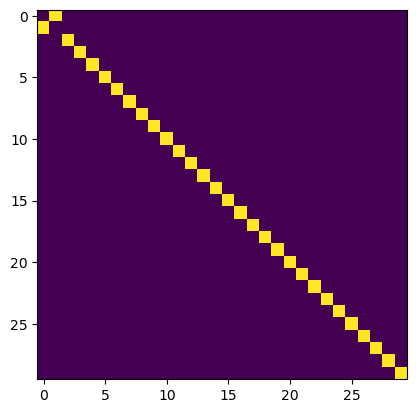

In [168]:
cost = torch.cdist(UV, xyz_permuted_rotated[:,:2], p=2)
p = q = np.ones(npts)
transport_plan, log = ot.emd(p, q, cost.numpy(), log=True)
plt.imshow(transport_plan)
log

In [169]:
xyz_permuted_unpermuted = torch.from_numpy(transport_plan) @ xyz_init
xyz_permuted_unpermuted

tensor([[-2.3342e+00, -1.7046e-01, -6.4547e-06],
        [ 9.1866e-01, -9.6777e-01,  2.5724e-05],
        [-6.9637e-01, -8.0883e-01, -2.0245e-05],
        [ 1.5460e+00,  1.8964e-01, -6.8301e-06],
        [ 1.0245e+00, -1.3212e+00,  4.3130e-06],
        [ 3.5011e-01,  1.2347e-01, -3.6563e-06],
        [-1.3195e+00, -6.1429e-01, -5.3123e-06],
        [ 2.2494e-01,  1.5819e-01, -1.3408e-06],
        [ 9.8619e-01, -3.2989e-01, -9.8851e-06],
        [-1.6490e+00, -5.4536e-01,  7.2555e-06],
        [-5.2437e-01, -8.4853e-01,  8.1991e-08],
        [ 5.5338e-01, -5.7897e-02,  2.3697e-06],
        [-1.3582e+00, -1.0050e+00, -1.5195e-05],
        [ 9.7970e-01,  5.7071e-01,  1.0216e-05],
        [-9.7852e-01,  1.9655e+00,  6.0316e-06],
        [ 1.2171e-01, -1.3646e+00, -1.5447e-05],
        [-3.1432e+00,  1.6083e-01, -1.0950e-06],
        [-7.1385e-01, -5.2701e-01,  1.0134e-05],
        [ 9.8317e-01,  8.6544e-01,  5.2988e-07],
        [-2.0428e+00,  2.2648e-01, -1.0986e-05],
        [-1.9672e-01

Permute points, and find optimal rotation given this ordering

In [170]:
rotation_new = solutions.make_R_tilde(xyz_permuted_unpermuted.numpy(),UV.numpy())
rotation_new_bi = solutions.make_M_opt_rot(xyz_permuted_unpermuted.numpy(),UV.numpy())

U,S,Vh = np.linalg.svd(rotation_new)
rotation_new, rotation, U@Vh, rotation_new_bi

(array([[ 0.99619698, -0.08715363, -0.25568683],
        [ 0.08715753,  0.99619514, -0.22591303],
        [ 0.27440312,  0.20276884,  1.00000269]]),
 array([[ 0.9961947 , -0.08715574,  0.        ],
        [ 0.08715574,  0.9961947 ,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.96390742, -0.11101399, -0.24198838],
        [ 0.05862786,  0.9751144 , -0.21380991],
        [ 0.25970224,  0.1919057 ,  0.94642852]]),
 array([[ 0.96390742, -0.11101399, -0.24198838],
        [ 0.05862786,  0.9751144 , -0.21380991],
        [ 0.25970224,  0.1919057 ,  0.94642852]]))

In [171]:
torch.allclose((xyz_permuted_unpermuted @ rotation.T)[:, :2], UV, atol=1e-3)

/tmp/ipykernel_2434601/2424785271.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  torch.allclose((xyz_permuted_unpermuted @ rotation.T)[:, :2], UV, atol=1e-3)


True

In [172]:
torch.allclose((xyz_permuted_unpermuted @ rotation_new.T)[:, :2], UV, atol=1e-4)

/tmp/ipykernel_2434601/4215844760.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  torch.allclose((xyz_permuted_unpermuted @ rotation_new.T)[:, :2], UV, atol=1e-4)


True

In [173]:
torch.allclose((xyz_permuted_unpermuted @ (U@Vh).T)[:, :2], UV, atol=3e-1)

/tmp/ipykernel_2434601/2091390297.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  torch.allclose((xyz_permuted_unpermuted @ (U@Vh).T)[:, :2], UV, atol=3e-1)


True

Proceed another iteration, updating the points with the rotation

/tmp/ipykernel_2434601/2192762385.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  xyz_permuted_rotated = xyz_init @ rotation_new.T


{'cost': 0.00040105434879590587,
 'u': array([6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06, 6.68423915e-06, 6.68423915e-06,
        6.68423915e-06, 6.68423915e-06]),
 'v': array([ 2.82850393e-06,  6.14437121e-06,  2.44956495e-06,  9.89772055e-06,
         1.38528481e-05,  1.22293161e-05,  3.93170617e-06,  7.27393049e-06,
         1.39254760e-06,  1.48534880e-06,  1.37555752e-07, -2.68999350e-07,
         5.70942486e-06,  2.43581930e-06,  1.72085078e-05,  6.42286326e-06,
         7.97032370e-06,  1.01346507e-05,  9.45546574e-06,  3.47087759e-06,
         5.03409122e-06,  4.600

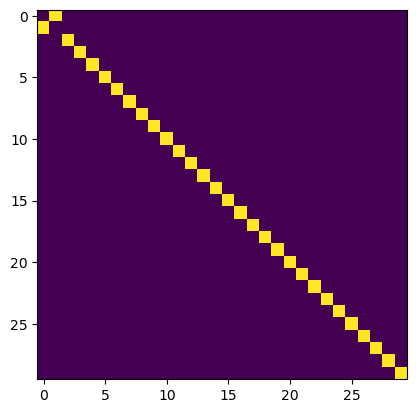

In [174]:
xyz_permuted_rotated = xyz_init @ rotation_new.T

cost = torch.cdist(UV, xyz_permuted_rotated[:,:2], p=2)
p = q = np.ones(npts)
transport_plan, log = ot.emd(p, q, cost.numpy(), log=True)
plt.imshow(transport_plan)
log

In [175]:
transport_plan, rotation, logs = procrustes_wasserstein_2d_3d_dram(xyz_init, UV, verbose_log=True, cost_d=2, tol=-np.inf, max_iter=2)

In [176]:
rotation = torch.from_numpy(R.from_euler('zyz', [5,5,5], degrees=True).as_matrix())
Rxy = rotation[:,:2]
U, S, Vh = torch.linalg.svd(Rxy, full_matrices=True)

Rxy_est = U[:,:2] @ Vh
Rz_est = torch.linalg.cross(Rxy_est[:,0],Rxy_est[:,1])
R_est = torch.cat([Rxy_est, Rz_est.reshape(3,1)], 1)
torch.allclose(rotation, R_est)
# U[:,:2].shape, S.shape, Vh.shape

True

# `procrustes_wasserstein_2d_3d_dram` function

In [686]:
torch.manual_seed(0)

npts = 10
xyz = torch.randn(npts, 3, dtype=torch.double)
# xyz[:,2] = torch.randn(npts, dtype=torch.double) * 0.01
UV = xyz[:,:2] + torch.randn(npts, 2, dtype=torch.double) * 0.00001

permutation_idx = torch.arange(npts)
k_permute = 0#npts
permutation_idx[:k_permute] = torch.randperm(k_permute)
rotation_gt = R.from_euler('zyz', [10,0,0], degrees=True).as_matrix()
xyz_permuted_rotated = xyz[permutation_idx] @ rotation_gt
xyz_init = xyz_permuted_rotated.clone()


/tmp/ipykernel_2434601/1655601102.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  xyz_permuted_rotated = xyz[permutation_idx] @ rotation_gt


In [649]:
utils.least_squares_4_3D(np.eye(3), xyz.numpy(),UV.numpy())

np.float64(1.2015608577919129e-08)

In [650]:
transport_plan, rotation, logs = procrustes_wasserstein_2d_3d_dram(xyz_init, UV, verbose_log=True, cost_d=2, tol=1e-6, max_iter=30)
logs

[{'cost': 3.084096459116468,
  'u': array([ 0.43013108, -0.18938078, -0.07631872, -0.1622795 , -0.20080086,
          0.05902444,  0.13310809,  0.08427718, -0.12266229,  0.13644438,
         -0.0512841 , -0.04221349,  0.28056651, -0.18644095, -0.13425029,
          0.08487117,  0.93373647, -0.07621395, -0.16586755,  0.34534305,
          0.5632656 , -0.06339663, -0.09410297, -0.15572452, -0.13747658,
         -0.13425029,  0.77823651, -0.03786007, -0.13425029, -0.03720962,
         -0.09724358,  0.10516207,  0.58506853, -0.13425029, -0.07136306,
          0.19837308, -0.13425029, -0.09927376, -0.1902115 , -0.14699032,
         -0.13425029,  0.33156495, -0.13425029,  0.05709026, -0.08518242,
          0.1766603 , -0.06338416,  0.04582184, -0.14793421, -0.14612961]),
  'v': array([-0.19794623, -0.53708833, -0.10292857,  0.22550109,  0.05162344,
          0.10013937, -0.03763492,  0.08150997,  0.18115438,  0.25914478,
         -0.56276162,  0.28074016,  0.15551949,  0.09146511, -0.0687462

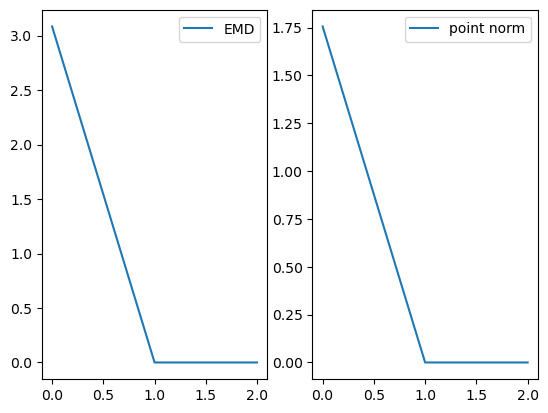

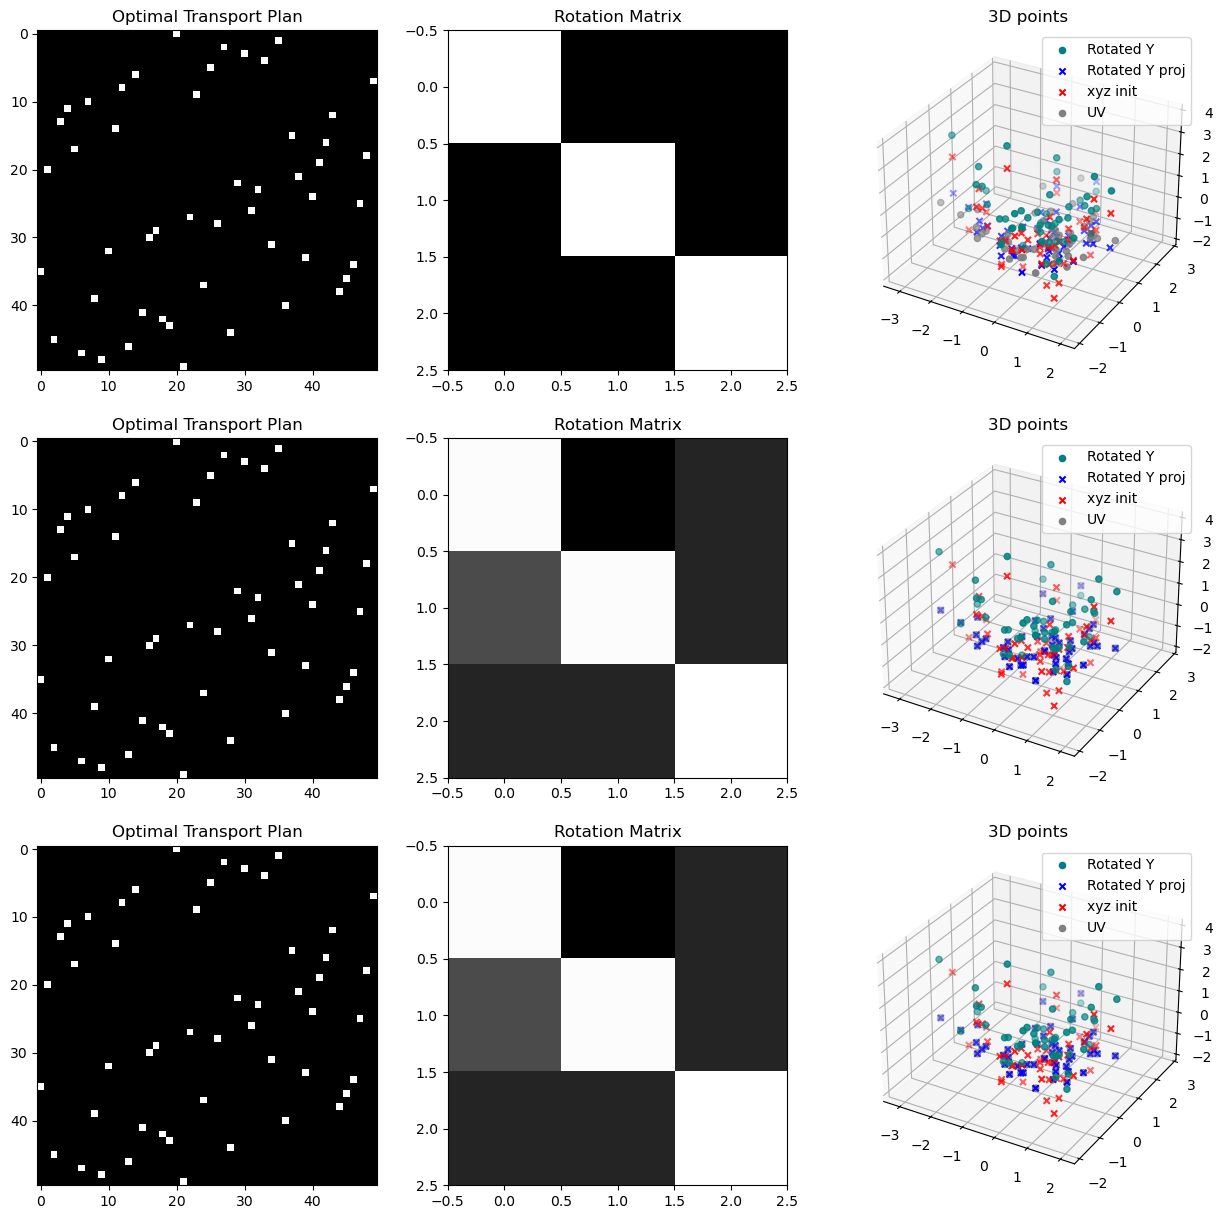

In [651]:
n_pl = min(10, len(logs))
X = UV.numpy()
transport_plans = [log['transport_plan'] for log in logs[:n_pl]]
Ps = [log['R'] for log in logs[:n_pl]]
YpRs = [log['xyz_permuted_R'] for log in logs[:n_pl]]

fig, axes = plt.subplots(1,2)
axes[0].plot([log['cost'] for log in logs], label='EMD')
axes[0].legend()
axes[1].plot([log['point_norm'] for log in logs], label='point norm')
axes[1].legend()
plt.show()


# plot these three
fig, axes = plt.subplots(n_pl, 3, figsize=(15, 5*n_pl), )
for idx in range(len(transport_plans)):
    axes[idx, 0].imshow(transport_plans[idx], cmap='gray')
    axes[idx,0].set_title('Optimal Transport Plan')
    axes[idx,1].imshow(Ps[idx], cmap='gray')
    axes[idx,1].set_title('Rotation Matrix')

    axes[idx, 2].remove()

    # Rotated Y with X in 3D
    ax2 = fig.add_subplot(n_pl, 3, 3 * idx + 3, projection='3d')
    ax2.scatter(xs=YpRs[idx][:, 0], ys=YpRs[idx][:, 1], zs=YpRs[idx][:, 2]+1, label='Rotated Y', marker='o', color='teal')
    ax2.scatter(xs=YpRs[idx][:, 0], ys=YpRs[idx][:, 1], zs=0, label='Rotated Y proj', marker='x', color='blue')
    ax2.scatter(xs=xyz_permuted_rotated[:, 0], ys=xyz_permuted_rotated[:, 1], zs=xyz_permuted_rotated[:, 2], label='xyz init', marker='x', color='red')
    ax2.scatter(xs=UV[:, 0], ys=UV[:, 1], zs=0, label='UV', marker='o', color='gray')
    ax2.set_title('3D points')
    ax2.legend()






# `procrustes_wasserstein_2d_3d_svd` 

## walk thorugh

We want to recover this rotation and ordering

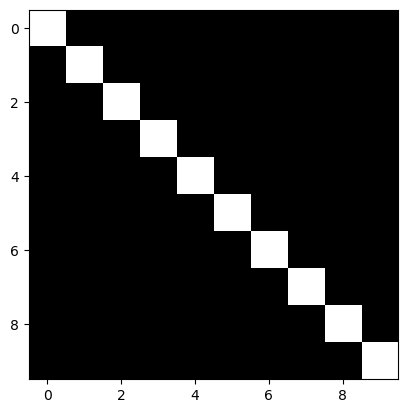

In [689]:
inverse_permutation_idx = torch.argsort(permutation_idx)
transport_plan_gt = torch.zeros(npts,npts)
transport_plan_gt[torch.arange(npts), inverse_permutation_idx] = 1
plt.imshow(transport_plan_gt, cmap='gray')

In [690]:
np.allclose((transport_plan_gt @ xyz_init.float() @ rotation_gt.T)[:,:2], xyz[:,:2]) 

/tmp/ipykernel_2434601/2607192233.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.allclose((transport_plan_gt @ xyz_init.float() @ rotation_gt.T)[:,:2], xyz[:,:2])


True

In [691]:
np.linalg.norm((transport_plan_gt @ xyz_init.float() @ rotation_gt.T)[:,:2] - UV.numpy()) 

/tmp/ipykernel_2434601/3987034288.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.linalg.norm((transport_plan_gt @ xyz_init.float() @ rotation_gt.T)[:,:2] - UV.numpy())


np.float64(5.343842962469644e-05)

### round 1

Calculate cost between points

In [692]:
cost = torch.cdist(UV, xyz_init[:,:2], p=2)**2

Solve transport problem to find correspondence

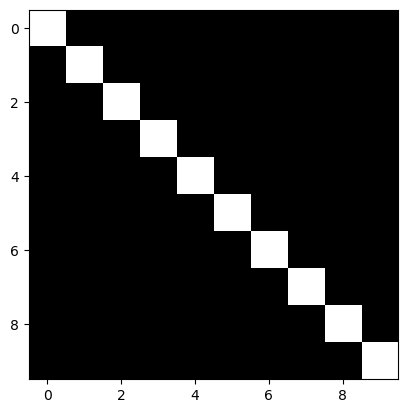

In [693]:
p = q = torch.ones(npts)
transport_plan, log = ot.emd(p.numpy(), q.numpy(), cost.numpy(), log=True)
plt.imshow(transport_plan, cmap='gray')
assert np.allclose(transport_plan_gt, transport_plan)

Estimate rotation that matches them with svd

In [736]:
# Rxy_estimate = xyz_init.T @ transport_plan.T @ UV
Rxy_estimate = xyz_init.T @ UV
Rxy_estimate, rotation_gt

(tensor([[16.3899,  2.5499],
         [-1.6825,  7.6135],
         [ 3.6651,  2.0888]], dtype=torch.float64),
 array([[ 0.98480775, -0.17364818,  0.        ],
        [ 0.17364818,  0.98480775,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

Project to Steifel and fill out missing column

In [740]:
U, _, Vh = torch.linalg.svd(Rxy_estimate, full_matrices=False)
Rxy_projected = U[:,:2] @ Vh
Rz_est = torch.linalg.cross(Rxy_projected[:,0],Rxy_projected[:,1])
rotation_new = torch.cat([Rxy_projected, Rz_est.reshape(3,1)], dim=1)
rotation_new

tensor([[ 0.9626,  0.1394, -0.2325],
        [-0.1843,  0.9655, -0.1842],
        [ 0.1988,  0.2201,  0.9550]], dtype=torch.float64)

In [741]:
Rxy_projected.T @ Rxy_projected

tensor([[ 1.0000e+00, -9.4236e-18],
        [-9.4236e-18,  1.0000e+00]], dtype=torch.float64)

In [743]:
s_opt = np.linalg.norm(( xyz_init.float() @ Rxy_projected.float())- UV[:,:2].numpy()) 

s_gt = np.linalg.norm((xyz_init.float() @ rotation_gt.T[:,:2])- UV[:,:2].numpy()) 
s_opt, s_gt

/tmp/ipykernel_2434601/1977885710.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  s_opt = np.linalg.norm(( xyz_init.float() @ Rxy_projected.float())- UV[:,:2].numpy())
/tmp/ipykernel_2434601/1977885710.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  s_gt = np.linalg.norm((xyz_init.float() @ rotation_gt.T[:,:2])- UV[:,:2].numpy())


(np.float64(1.0359930351670126), np.float64(5.343842962469644e-05))

In [747]:
P_true.shape

torch.Size([3, 2])

In [742]:
# s_opt = np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ Rxy_projected.float())- UV[:,:2].numpy()) 

# s_gt = np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_gt.T[:,:2])- UV[:,:2].numpy()) 

/tmp/ipykernel_2434601/1102234704.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  s_gt = np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_gt.T[:,:2])- UV[:,:2].numpy())


array([[ 1.0000000e+00, -5.1689684e-18],
       [-5.1689684e-18,  1.0000000e+00]])

In [ ]:
# Rz_est = torch.linalg.cross(Rxy_projected[0],Rxy_projected[1])
# rotation_new = torch.cat([Rxy_projected, Rz_est.reshape(1,3)], dim=0)
# rotation_new

RuntimeError: linalg.cross: inputs dimension -1 must have length 3. Got 2 and 2

In [727]:
Rxy_projected = Rxy_estimate
Rz_est = torch.linalg.cross(Rxy_projected[:,0],Rxy_projected[:,1])
rotation_new_ = torch.cat([Rxy_projected, Rz_est.reshape(3,1)], dim=1)

U, _, Vh = torch.linalg.svd(rotation_new_, full_matrices=True)
rotation_new_ = U @ Vh

torch.allclose(rotation_new_, rotation_new)


True

Let's rotate the xyz point cloud and check how much closer the projection is. Note that to compoute this, we need a transport plan for correspondence. If we estimate it well, then the norm (which demands a correspondence of points) will be small.

In [728]:
np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - xyz[:,:2].numpy()) 

/tmp/ipykernel_2434601/1726868406.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - xyz[:,:2].numpy())


np.float64(1.0359976084143734)

### round 2

Using this new rotation, we recompute the cost

In [661]:
cost = torch.cdist(UV, (xyz_init @ rotation_new)[:,:2], p=2)**2

And we recompute the transport plan

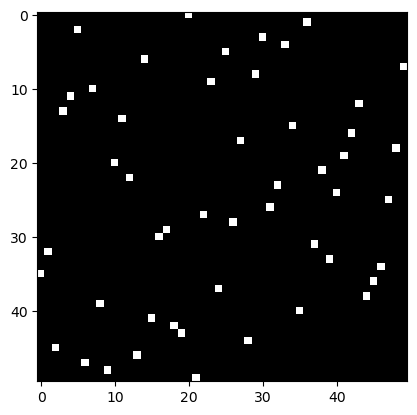

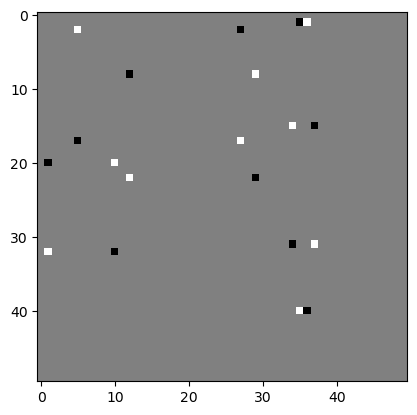

In [662]:
transport_plan, log = ot.emd(p.numpy(), q.numpy(), cost.numpy(), log=True)
plt.imshow(transport_plan, cmap='gray')
plt.show()
plt.imshow(transport_plan-transport_plan_gt.numpy(), cmap='gray')

Steifel and SO(3)

In [663]:
Rxy_estimate = xyz_init.T @ transport_plan.T @ UV
Rxy_estimate, rotation_gt

/tmp/ipykernel_2434601/3996916833.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rxy_estimate = xyz_init.T @ transport_plan.T @ UV


(tensor([[ 57.5403,   4.6403],
         [-12.9157,  42.0245],
         [ -4.1419, -11.2296]], dtype=torch.float64),
 array([[ 0.98480775, -0.17364818,  0.        ],
        [ 0.17364818,  0.98480775,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

In [664]:
U, _, Vh = torch.linalg.svd(Rxy_estimate, full_matrices=True)
Rxy_projected = U[:,:2] @ Vh
Rz_est = torch.linalg.cross(Rxy_projected[:,0],Rxy_projected[:,1])
rotation_new = torch.cat([Rxy_projected, Rz_est.reshape(3,1)], dim=1)
rotation_new

tensor([[ 0.9799,  0.1563,  0.1239],
        [-0.1827,  0.9526,  0.2434],
        [-0.0800, -0.2611,  0.9620]], dtype=torch.float64)

Depending on how good the new transport plan and rotation matrix are, the projected points may now be closer

In [665]:
np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy()) 

/tmp/ipykernel_2434601/3162566192.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy())


np.float64(1.7142325831159269)

### round 3

In [666]:
cost = torch.cdist(UV, (xyz_init @ rotation_new)[:,:2], p=2)**2

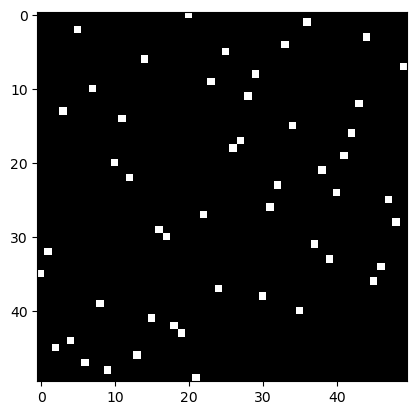

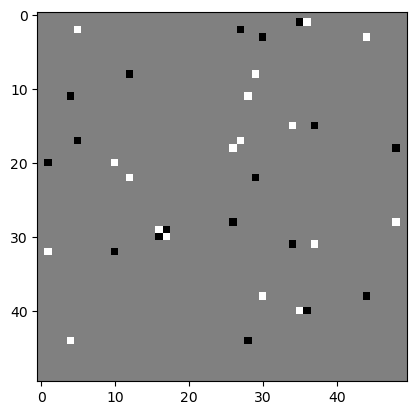

In [667]:
transport_plan, log = ot.emd(p.numpy(), q.numpy(), cost.numpy(), log=True)
plt.imshow(transport_plan, cmap='gray')
plt.show()
plt.imshow(transport_plan-transport_plan_gt.numpy(), cmap='gray')

In [668]:
Rxy_estimate = xyz_init.T @ transport_plan.T @ UV
Rxy_estimate, rotation_gt

/tmp/ipykernel_2434601/3996916833.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rxy_estimate = xyz_init.T @ transport_plan.T @ UV


(tensor([[ 57.4606,   4.5357],
         [-12.9708,  41.8231],
         [ -4.6358, -12.3562]], dtype=torch.float64),
 array([[ 0.98480775, -0.17364818,  0.        ],
        [ 0.17364818,  0.98480775,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

In [669]:
U, _, Vh = torch.linalg.svd(Rxy_estimate, full_matrices=True)
Rxy_projected = U[:,:2] @ Vh
Rz_est = torch.linalg.cross(Rxy_projected[:,0],Rxy_projected[:,1])
rotation_new = torch.cat([Rxy_projected, Rz_est.reshape(3,1)], dim=1)
rotation_new

tensor([[ 0.9787,  0.1524,  0.1372],
        [-0.1847,  0.9459,  0.2669],
        [-0.0891, -0.2866,  0.9539]], dtype=torch.float64)

In [670]:
np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy()) 

/tmp/ipykernel_2434601/3162566192.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.linalg.norm((torch.from_numpy(transport_plan) @ xyz_init.float() @ rotation_new.float())[:,:2] - UV[:,:2].numpy())


np.float64(1.8332780189885254)

## reason why optimizing on steiffel doesn't work...
- it solves the problem where we lift the 2D point cloud and compoute the residual in 3D
- it does not solve the problem where we project the 3D point cloud and minimize the residual in 2D

In [798]:
import torch

# Set random seed for reproducibility
torch.manual_seed(42)

# Step 1: Generate a random 2D point cloud X (n x 2)
n = 10
X = torch.randn(n, 2)  # Shape (n,2)

# Step 2: Create a ground-truth Stiefel matrix P_true (3x2)
Q, _ = torch.linalg.qr(torch.randn(3, 2))  # QR decomposition to get an orthonormal basis
P_true = Q  # Shape (3,2)

# Step 3: Generate the transformed point cloud Y (n x 3)
Y = X @ P_true.T  # Shape (n,3)

# Step 4: Solve for the optimal Stiefel matrix P
M = Y.T @ X  # Compute cross-covariance (3x2)
U, _, Vh = torch.linalg.svd(M, full_matrices=False)  # Compute SVD
P_opt = U @ Vh  # Optimal Stiefel matrix (3x2)

# Step 5: Compare P_opt and P_true
print("Ground truth P (3x2):\n", P_true)
print("\nRecovered P_opt (3x2):\n", P_opt)
print("\nDifference (P_opt - P_true):\n", P_opt - P_true)
print("\nOrthogonality check (P_opt.T @ P_opt):\n", P_opt.T @ P_opt)
error = torch.norm(Y - X @ P_opt.T)
print("\nError (Frobenius norm):", error.item())


Ground truth P (3x2):
 tensor([[-0.4821, -0.3637],
        [ 0.8515,  0.0197],
        [-0.2063,  0.9313]])

Recovered P_opt (3x2):
 tensor([[-0.4821, -0.3637],
        [ 0.8515,  0.0197],
        [-0.2063,  0.9313]])

Difference (P_opt - P_true):
 tensor([[ 0.0000e+00,  5.9605e-08],
        [-1.1921e-07, -2.7940e-08],
        [ 4.4703e-08,  2.3842e-07]])

Orthogonality check (P_opt.T @ P_opt):
 tensor([[ 1.0000e+00, -7.8146e-08],
        [-7.8146e-08,  1.0000e+00]])

Error (Frobenius norm): 1.014868189486151e-06


In [ ]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation

# Step 1: Generate a random 2D point cloud X (n x 2)
torch.manual_seed(42)
n = 10
X = torch.randn(n, 2)  # Shape (n,2)

# Step 2: Generate a random 3D rotation matrix R_true
angles = np.random.uniform(low=-np.pi, high=np.pi, size=3)  # Random Euler angles
R_true = Rotation.from_euler('xyz', angles).as_matrix()  # Shape (3x3)

# Step 3: Extract the first two columns to form the true Stiefel matrix P_true (3x2)
P_true = torch.tensor(R_true[:, :2], dtype=torch.float32)  # Shape (3x2)

# Step 4: Generate the transformed point cloud Y (n x 3)
torch.manual_seed(42)
noise = 0.1 * torch.randn(n, 3)  # Add noise to the points
Y = X @ P_true.T + noise # Shape (n,3)
point_norm_gt = torch.norm(noise)
point_norm_gt_t = torch.norm(noise @ P_true)

# Step 5: Solve for the optimal Stiefel matrix P_opt
M = Y.T @ X  # Compute cross-covariance (3x2)
U, _, Vh = torch.linalg.svd(M, full_matrices=False)  # Compute SVD
P_opt = U @ Vh  # Optimal Stiefel matrix (3x2)

point_norm_opt = torch.norm(Y - X @ P_opt.T)

# Step 6: Recover the full 3x3 rotation matrix using Gram-Schmidt
def extend_to_so3(P):
    """ Extend a 3x2 Stiefel matrix to a full 3x3 rotation matrix in SO(3). """
    e1, e2 = P[:, 0], P[:, 1]  # First two columns
    e3 = torch.cross(e1, e2)  # Compute third column via cross product
    R = torch.stack([e1, e2, e3], dim=1)  # Form full rotation matrix
    return R

R_opt = extend_to_so3(P_opt)  # Recover full rotation matrix

point_norm_opt_t = torch.norm(Y @ P_opt - X )
point_norm_opt_t_rot = torch.norm(Y @ R_opt[:,:2] - X )

# Step 7: Compare results
print("Ground truth R (3x3):\n", R_true)
print("\nRecovered R_opt (3x3):\n", R_opt.numpy())
print("\nDifference (R_opt - R_true):\n", R_opt.numpy() - R_true)
print("\nOrthogonality check (R_opt.T @ R_opt):\n", R_opt.T @ R_opt)
print("\nDeterminant of R_opt (should be ~1):", torch.det(R_opt).item())

print("\nPoint norm (ground truth):", point_norm_gt.item())
print("Point norm (optimal):", point_norm_opt.item())

print("\nPoint norm (ground truth) t:", point_norm_gt_t.item())
print("Point norm (optimal) t:", point_norm_opt_t.item())
print("Point norm (optimal) t rot:", point_norm_opt_t_rot.item())

Ground truth R (3x3):
 [[-0.29813174  0.23476196  0.925205  ]
 [-0.06762079 -0.97204259  0.2248569 ]
 [ 0.95212651  0.00447389  0.30567154]]

Recovered R_opt (3x3):
 [[-0.24778602  0.30589247  0.9192564 ]
 [-0.04879655 -0.9515824   0.30349627]
 [ 0.9675853   0.03034557  0.2507153 ]]

Difference (R_opt - R_true):
 [[ 0.05034573  0.0711305  -0.00594861]
 [ 0.01882424  0.02046022  0.07863937]
 [ 0.01545881  0.02587168 -0.05495626]]

Orthogonality check (R_opt.T @ R_opt):
 tensor([[ 1.0000e+00, -1.6020e-08, -1.4442e-08],
        [-1.6020e-08,  1.0000e+00,  9.6543e-09],
        [-1.4442e-08,  9.6543e-09,  1.0000e+00]])

Determinant of R_opt (should be ~1): 1.0000004768371582

Point norm (ground truth): 0.6695717573165894
Point norm (optimal): 0.58660489320755

Point norm (ground truth) t: 0.5248221158981323
Point norm (optimal) t: 0.5263671875
Point norm (optimal) t rot: 0.5263671875


In [758]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation

# Step 1: Generate a random 3D point cloud Y (n x 3)
torch.manual_seed(42)
n = 10
Y = torch.randn(n, 3)  # Shape (n,3)

# Step 2: Generate a random 3D rotation matrix R_true
angles = np.random.uniform(low=-np.pi, high=np.pi, size=3)  # Random Euler angles
R_true = Rotation.from_euler('xyz', angles).as_matrix()  # Shape (3x3)

# Step 3: Extract the first two columns to form the ground-truth Stiefel matrix P_true (3x2)
P_true = torch.tensor(R_true[:, :2], dtype=torch.float32)  # Shape (3x2)

# Step 4: Generate the projected 2D point cloud X (n x 2)
noise_eps = 0
noise = noise_eps * torch.randn(n, 2)  # Add noise to the points
X = Y @ P_true + noise # Shape (n,2)

point_norm_gt = torch.norm(noise)

# Step 5: Solve for the optimal Stiefel matrix P_opt using SVD
M = Y.T @ X  # Compute cross-covariance (3x2)
U, _, Vh = torch.linalg.svd(M, full_matrices=False)  # Compute SVD
P_opt = U @ Vh  # Optimal Stiefel matrix (3x2)

point_norm_opt = torch.norm(X - Y @ P_opt)

# Step 6: Recover the full 3x3 rotation matrix using Gram-Schmidt
def extend_to_so3(P):
    """ Extend a 3x2 Stiefel matrix to a full 3x3 rotation matrix in SO(3). """
    e1, e2 = P[:, 0], P[:, 1]  # First two columns
    e3 = torch.cross(e1, e2)  # Compute third column via cross product
    R = torch.stack([e1, e2, e3], dim=1)  # Form full rotation matrix
    return R

R_opt = extend_to_so3(P_opt)  # Recover full rotation matrix

# Step 7: Compare results
print("Ground truth R (3x3):\n", R_true)
print("\nRecovered R_opt (3x3):\n", R_opt.numpy())
print("\nDifference (R_opt - R_true):\n", R_opt.numpy() - R_true)
print("\nOrthogonality check (R_opt.T @ R_opt):\n", R_opt.T @ R_opt)
print("\nDeterminant of R_opt (should be ~1):", torch.det(R_opt).item())

print("\nPoint norm (ground truth):", point_norm_gt.item())
print("Point norm (optimal):", point_norm_opt.item())


Ground truth R (3x3):
 [[-0.99081123 -0.11329566 -0.07387287]
 [-0.13435931  0.88713835  0.44151232]
 [ 0.01551403  0.44738087 -0.89420896]]

Recovered R_opt (3x3):
 [[-0.9860319  -0.11369893  0.12171021]
 [-0.03233538  0.8475231   0.5297726 ]
 [-0.16338679  0.51843727 -0.8393613 ]]

Difference (R_opt - R_true):
 [[ 0.00477934 -0.00040326  0.19558308]
 [ 0.10202393 -0.03961525  0.08826026]
 [-0.17890082  0.07105639  0.05484765]]

Orthogonality check (R_opt.T @ R_opt):
 tensor([[ 1.0000e+00, -9.4059e-09,  9.4553e-09],
        [-9.4059e-09,  1.0000e+00, -1.6485e-08],
        [ 9.4553e-09, -1.6485e-08,  1.0000e+00]])

Determinant of R_opt (should be ~1): 0.9999998211860657

Point norm (ground truth): 0.0
Point norm (optimal): 0.8428195714950562


In [783]:
import torch

# # Step 1: Define the matrices X (n x 2) and Y (n x 3)
# torch.manual_seed(42)
# n = 10
# X = torch.randn(n, 2)  # Shape (n, 2)
# Y = torch.randn(n, 3)  # Shape (n, 3)

# Step 1: Generate a random 3D point cloud Y (n x 3)
torch.manual_seed(42)
n = 10
Y = torch.randn(n, 3)  # Shape (n,3)

# Step 2: Generate a random 3D rotation matrix R_true
angles = np.random.uniform(low=-np.pi, high=np.pi, size=3)  # Random Euler angles
R_true = Rotation.from_euler('xyz', 0*angles).as_matrix()  # Shape (3x3)

# Step 3: Extract the first two columns to form the ground-truth Stiefel matrix P_true (3x2)
P_true = torch.tensor(R_true[:, :2], dtype=torch.float32)  # Shape (3x2)

# Step 4: Generate the projected 2D point cloud X (n x 2)
noise_eps = 0
noise = noise_eps * torch.randn(n, 2)  # Add noise to the points
X = Y @ P_true + noise # Shape (n,2)

# Step 2: Compute the matrix M = Y^T X (3 x 2)
M = X.T @ Y  # Shape (3, 2)

# Step 3: Perform SVD on M to extract the optimal P
U, _, Vh = torch.linalg.svd(M, full_matrices=True)  # SVD decomposition

# Step 4: The optimal P is the first two columns of U (orthonormal matrix)
P_opt = Vh.T[:, :2] @ U.T # Shape (3, 2)

# Step 5: Verify that P^T P = I_2 (orthonormality check)
print("P^T P:\n", P_opt @ P_opt.T)

# Step 6: Calculate the Frobenius norm to verify optimization
reconstruction_error = torch.norm(X - Y @ P_opt, p='fro')**2
print(f"Reconstruction error (Frobenius norm): {reconstruction_error.item()}")
# Step 6: Calculate the Frobenius norm to verify optimization
reconstruction_error_true = torch.norm(X - Y @ P_true, p='fro')**2
print(f"Reconstruction error (Frobenius norm) gt: {reconstruction_error_true.item()}")


P^T P:
 tensor([[ 0.9377, -0.0219,  0.2407],
        [-0.0219,  0.9923,  0.0845],
        [ 0.2407,  0.0845,  0.0700]])
Reconstruction error (Frobenius norm): 1.0959687232971191
Reconstruction error (Frobenius norm) gt: 0.0


In [784]:
P_opt.shape

torch.Size([3, 2])

In [809]:
import torch

# Step 1: Generate a random 3D point cloud Y (n x 3)
torch.manual_seed(42)
n = 10
Y = torch.randn(n, 3)  # Shape (n,3)

# Step 2: Generate a random 3D rotation matrix R_true
np.random.seed(42)
angles = np.random.uniform(low=-np.pi, high=np.pi, size=3)  # Random Euler angles
R_true = Rotation.from_euler('xyz', angles).as_matrix()  # Shape (3x3)

# Step 3: Extract the first two columns to form the ground-truth Stiefel matrix P_true (3x2)
P_true = torch.tensor(R_true[:, :2], dtype=torch.float32)  # Shape (3x2)

# Step 4: Generate the projected 2D point cloud X (n x 2)
noise_eps = 0
noise = noise_eps * torch.randn(n, 2)  # Add noise to the points
X = Y @ P_true + noise # Shape (n,2)

# Step 2: Compute the matrix M = Y^T X (3 x 2)
M = Y.T @ X  # Shape (3, 2)

# Step 3: Perform SVD on M to extract the optimal P
U, _ = torch.linalg.qr(M, )  # SVD decomposition

# Step 4: The optimal P is the first two columns of U (orthonormal matrix)
P_opt = -U[:, :2]  # Shape (3, 2)

# Step 5: Verify that P^T P = I_2 (orthonormality check)
print("P^T P:\n", P_opt.T @ P_opt)

# Step 6: Calculate the Frobenius norm to verify optimization
reconstruction_error = torch.norm(X - Y @ -P_opt, p='fro')**2
print(f"Reconstruction error (Frobenius norm): {reconstruction_error.item()}")
reconstruction_error_true = torch.norm(X - Y @ P_true, p='fro')**2
print(f"Reconstruction error (Frobenius norm) gt: {reconstruction_error_true.item()}")


P^T P:
 tensor([[1., 0.],
        [0., 1.]])
Reconstruction error (Frobenius norm): 46.72550964355469
Reconstruction error (Frobenius norm) gt: 0.0


In [808]:
U, _, Vh = torch.linalg.svd(M, )  # SVD decomposition
U[:,:2] @ Vh, P_opt, P_true

(tensor([[-0.2333, -0.7010],
         [-0.8764, -0.1487],
         [-0.4213,  0.6975]]),
 tensor([[ 0.2190, -0.7056],
         [ 0.8732, -0.1665],
         [ 0.4354,  0.6888]]),
 tensor([[-0.1075, -0.7250],
         [-0.9463, -0.1351],
         [-0.3047,  0.6754]]))

In [797]:
Y, Y @ U[:,:2] @ Vh

(tensor([[ 1.9269,  1.4873,  0.9007],
         [-2.1055,  0.6784, -1.2345],
         [-0.0431, -1.6047, -0.7521],
         [ 1.6487, -0.3925, -1.4036],
         [-0.7279, -0.5594, -2.3169],
         [-0.2168, -1.3847, -0.8712],
         [-0.2234,  1.7174,  0.3189],
         [-0.4245, -0.8286,  0.3309],
         [-1.5576,  0.9956, -0.8798],
         [-0.6011, -1.2742,  2.1228]]),
 tensor([[ 1.1351,  2.3199],
         [-2.3628, -0.5569],
         [ 0.5766, -1.5750],
         [ 1.3552,  0.1018],
         [-0.7885, -1.2547],
         [ 0.3018, -1.4800],
         [-0.9384,  1.4748],
         [ 0.0802, -0.8498],
         [-1.9727,  0.0288],
         [ 0.4609, -0.9736]]))

In [817]:
qa_solution = solutions.make_R_tilde(Y.numpy(), X.numpy()).T
P_true, qa_solution



(tensor([[-0.1075, -0.7250],
         [-0.9463, -0.1351],
         [-0.3047,  0.6754]]),
 array([[-0.10752425, -0.7249507 , -0.68035656],
        [-0.946345  , -0.13513051,  0.29354897],
        [-0.3047454 ,  0.6754156 , -0.6715237 ]], dtype=float32))

In [819]:

# Step 6: Calculate the Frobenius norm to verify optimization
reconstruction_error = torch.norm(X - Y @ qa_solution[:,:2], p='fro')**2
print(f"Reconstruction error (Frobenius norm) qa: {reconstruction_error.item()}")

Reconstruction error (Frobenius norm) qa: 1.1725342918822435e-13


/tmp/ipykernel_2434601/1208254463.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  reconstruction_error = torch.norm(X - Y @ qa_solution[:,:2], p='fro')**2


cf. Everson, R. (1997). Orthogonal , but not Orthonormal , Procrustes Problems. Convergence, (4), 1–11.

In [834]:
import torch

# Step 1: Generate a random 3D point cloud Y (n x 3)
torch.manual_seed(42)
n = 10
B = torch.randn(3, n)  # Shape (n,3)

# Step 2: Generate a random 3D rotation matrix R_true
np.random.seed(42)
angles = np.random.uniform(low=-np.pi, high=np.pi, size=3)  # Random Euler angles
R_true = Rotation.from_euler('xyz', angles).as_matrix()  # Shape (3x3)

# Step 3: Extract the first two columns to form the ground-truth Stiefel matrix P_true (3x2)
U_true = torch.tensor(R_true[:2, :], dtype=torch.float32)  # Shape (2,3)
# it has 2 orthogonal rows, not orthogonal columns

# Step 4: Generate the projected 2D point cloud X (n x 2)
noise_eps = 0
noise = noise_eps * torch.randn(2, n)  # Add noise to the points
A = U_true @ B + noise # Shape (n,2)

# Step 2: Compute the matrix M = Y^T X (3 x 2)
M = A @ B.T  # Shape (3, 2)

# Step 3: Perform SVD on M to extract the optimal P
U, _, Vh = torch.linalg.svd(M, full_matrices=False)  # SVD decomposition
U.shape, Vh.shape

# # Step 4: The optimal P is the first two columns of U (orthonormal matrix)
U_opt = U @ Vh  # Shape (2, 3)


# # Step 5: Verify that P^T P = I_2 (orthonormality check)
print("P^T P:\n", P_opt @ P_opt.T)

# # Step 6: Calculate the Frobenius norm to verify optimization
reconstruction_error = torch.norm(A - U_opt @ B, p='fro')**2
print(f"Reconstruction error (Frobenius norm): {reconstruction_error.item()}")
reconstruction_error_true = torch.norm(A - U_true @ B, p='fro')**2
print(f"Reconstruction error (Frobenius norm) gt: {reconstruction_error_true.item()}")


P^T P:
 tensor([[1.0000e+00, 7.4506e-09],
        [7.4506e-09, 1.0000e+00]])
Reconstruction error (Frobenius norm): 0.32111480832099915
Reconstruction error (Frobenius norm) gt: 0.0


cf. slide 7 of https://convexoptimization.com/TOOLS/procrust94.pdf

In [837]:
import torch

# Step 1: Generate a random 3D point cloud Y (n x 3)
torch.manual_seed(42)
n = 10
B = torch.randn(n, 3)  # Shape (n,3)

# Step 2: Generate a random 3D rotation matrix R_true
np.random.seed(42)
angles = np.random.uniform(low=-np.pi, high=np.pi, size=3)  # Random Euler angles
R_true = Rotation.from_euler('xyz', angles).as_matrix()  # Shape (3x3)

# Step 3: Extract the first two columns to form the ground-truth Stiefel matrix P_true (3x2)
Q_true = torch.tensor(R_true[:,:2], dtype=torch.float32)  # Shape (2,3)
# it has 2 orthogonal rows, not orthogonal columns

# Step 4: Generate the projected 2D point cloud X (n x 2)
noise_eps = 0
noise = noise_eps * torch.randn(n, 2)  # Add noise to the points
A = B @ Q_true + noise # Shape (n,2)

# Step 2: Compute the matrix M = Y^T X (3 x 2)
M = B.T @ A  # Shape (3, 2)

# Step 3: Perform SVD on M to extract the optimal P
U, _, Vh = torch.linalg.svd(M, full_matrices=False)  # SVD decomposition
U.shape, Vh.shape

# # # Step 4: The optimal P is the first two columns of U (orthonormal matrix)
Q_opt = U @ Vh  # Shape (3, 2)


# # Step 5: Verify that P^T P = I_2 (orthonormality check)
print("P^T P:\n", Q_opt.T @ Q_opt)

# # Step 6: Calculate the Frobenius norm to verify optimization
reconstruction_error = torch.norm(A - B @ Q_opt, p='fro')**2
print(f"Reconstruction error (Frobenius norm): {reconstruction_error.item()}")
reconstruction_error_true = torch.norm(A - B @ Q_true, p='fro')**2
print(f"Reconstruction error (Frobenius norm) gt: {reconstruction_error_true.item()}")


P^T P:
 tensor([[1.0000e+00, 3.3635e-09],
        [3.3635e-09, 1.0000e+00]])
Reconstruction error (Frobenius norm): 0.6170976758003235
Reconstruction error (Frobenius norm) gt: 0.0


## function

In [687]:
transport_plan, rotation, logs = procrustes_wasserstein_2d_3d_svd(UV, xyz_init, p=torch.ones(npts), q=torch.ones(npts), verbose_log=True, tol=1e-6, max_iter=30)
logs

[{'cost': 0.7405901284999721,
  'u': array([0.0370295, 0.0370295, 0.0370295, 0.0370295, 0.0370295, 0.0370295,
         0.0370295, 0.0370295, 0.0370295, 0.0370295], dtype=float32),
  'v': array([ 0.1293978 ,  0.01705969, -0.0024146 ,  0.03669465,  0.04789516,
         -0.00918039,  0.00802574,  0.09371947, -0.02336569,  0.07246326],
        dtype=float32),
  'warning': None,
  'result_code': 1,
  'transport_plan': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32),
  'R': tensor([[1., 0., 0.],
          [0., 1., 0.],
     

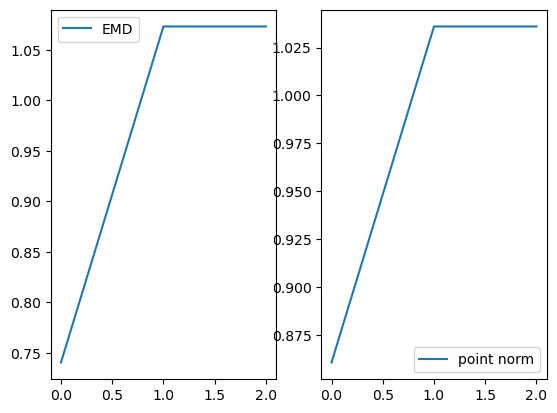

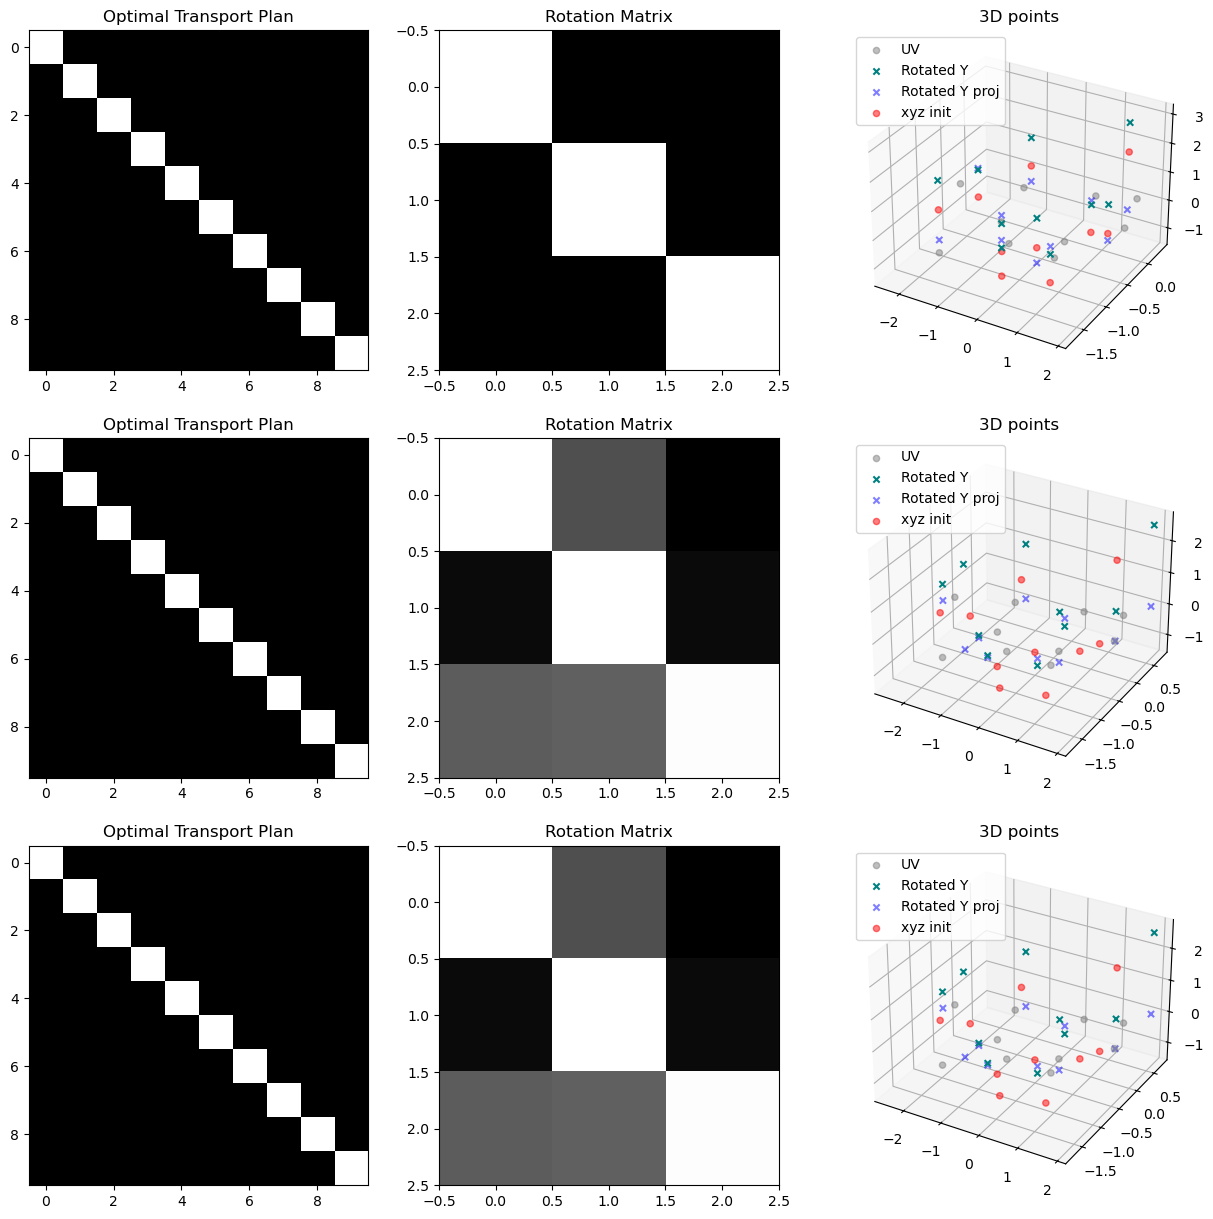

In [688]:
n_pl = min(10, len(logs))
X = UV.numpy()
transport_plans = [log['transport_plan'] for log in logs[:n_pl]]
Ps = [log['R'] for log in logs[:n_pl]]
YR = [log['YR'] for log in logs[:n_pl]]

fig, axes = plt.subplots(1,2)
axes[0].plot([log['cost'] for log in logs], label='EMD')
axes[0].legend()
axes[1].plot([log['point_norm'] for log in logs], label='point norm')
axes[1].legend()
plt.show()


# plot these three
fig, axes = plt.subplots(n_pl, 3, figsize=(15, 5*n_pl), )
for idx in range(len(transport_plans)):
    axes[idx, 0].imshow(transport_plans[idx], cmap='gray')
    axes[idx,0].set_title('Optimal Transport Plan')
    axes[idx,1].imshow(Ps[idx], cmap='gray')
    axes[idx,1].set_title('Rotation Matrix')

    axes[idx, 2].remove()

    # Rotated Y with X in 3D
    ax2 = fig.add_subplot(n_pl, 3, 3 * idx + 3, projection='3d')
    alpha = 0.5
    ax2.scatter(xs=UV[:, 0], ys=UV[:, 1], zs=0, label='UV', marker='o', color='gray', alpha=alpha)
    ax2.scatter(xs=YR[idx][:, 0], ys=YR[idx][:, 1], zs=YR[idx][:, 2]+1, label='Rotated Y', marker='x', color='teal', alpha=1)
    ax2.scatter(xs=YR[idx][:, 0], ys=YR[idx][:, 1], zs=0, label='Rotated Y proj', marker='x', color='blue', alpha=alpha)
    ax2.scatter(xs=xyz_init[:, 0], ys=xyz_init[:, 1], zs=xyz_init[:, 2], label='xyz init', marker='o', color='red', alpha=alpha)
    ax2.set_title('3D points')
    ax2.legend()




In [632]:
np.allclose((transport_plan @ YR[-1].numpy())[:,:2], UV, atol=1)

True

In [609]:
np.allclose((transport_plan @ xyz_init.numpy() @ rotation.numpy())[:,:2], UV, atol=1)

True